# Noised trajectories

In [30]:
import numpy as np
import numpy.random as alea
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from PlotFunctions import plot_signal, plot_position, plot_velocity, plot_variance

In [419]:
import pickle
import pandas as pd
record = pd.read_pickle('../2017_OptimalPrecision/DataRecording/dt_0.001/'+'HW_beta100.0_m1.0_dt0.001_k0.0005_niter1200000v_20.0.pkl')

In [261]:
def fact(n): 
    """The factorial function
    Returns n!, that is n x (n-1) x (n-2) x ... x 1
    Recursive implementation
    """
    if n == 0:
        return 1
    else:
        return(n*fact(n-1))

In [421]:
beta = 100 
m = 1
dt = 0.001 # step time
n = 2 # number of coordinates
k = 0.000005 # kind of accuracy parameter: the smaller k is, the more accurate is the pointing

In [422]:
# definition of A and B

A = np.zeros((n,n))
B = np.zeros(n)
for i in np.arange(n):
    for j in np.arange(i,n):
        A[i,j] = dt**(j-i)/fact(j-i)
A[n-1, n-1] = 1-dt*beta/m
B[n-1] = dt/m

In [423]:
t_T = .05# saccade duration
t_R = .05 # pursuit duration
T = int(np.round(t_T/dt))
R = int(np.round(t_R/dt))
time = np.linspace(0, t_T+t_R, R+T+1)
time_ms = time*1000
x0 = np.zeros(n) # starting point
xT = np.zeros(n) # ending point
xT[0] = 10
x0[0] = 0
#v = 10*np.cos(20*np.pi*time) # velocity of the target (deg/s)

In [424]:
def xT_f(t):
    return np.array([xT[0], 0])

In [425]:
xx = np.zeros(T+R+1)
vv = np.zeros(T+R+1)
for i in np.arange(T+R+1):
    xx[i] = xT[0]
    vv[i] = 0

In [426]:
def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))

def A_pow(A):
    A_pow_array = np.zeros((T+R+1,n,n))

    for i in np.arange(T+R+1):
        A_pow_array[i] = power(A,i)
    return A_pow_array

A_pow_array = A_pow(A)

def pow_fast(n):
    return A_pow_array[n]

ci0_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci0_array[i] = (pow_fast(i).dot(B))[0]

ci1_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci1_array[i] = (pow_fast(i).dot(B))[1]
    
#ci2_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci2_array[i] = (pow_fast(i).dot(B))[2]
    
#ci3_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci3_array[i] = (pow_fast(i).dot(B))[3]

ci = np.array([ci0_array, ci1_array])

In [427]:
def state_vector(u, t):
    if t == 0:
        return x0
    else:
        w = np.zeros(len(u))
        for i in np.arange(t):
            if t < T:
                w[i] = alea.normal(0,k*(u[i])**2)
            else:
                w[i] = 0
        return (ci[:,0:t]*np.flipud(u[0:t]+w[0:t])).sum(axis = 1)

In [428]:
def expectation(u, t):
    """Computation of the expectation of the state vector at time t, given u
    """
    if t == 0:
        return x0
    else:
        return (ci[:,0:t]*np.flipud(u[0:t])).sum(axis = 1)

In [429]:
def variance(u, t):
    """Computation of the variance of the state vector at time t, given u
    """
    return (m**2)*k*(np.flipud(ci0_array[0:t]**2)*u[0:t]**2).sum()

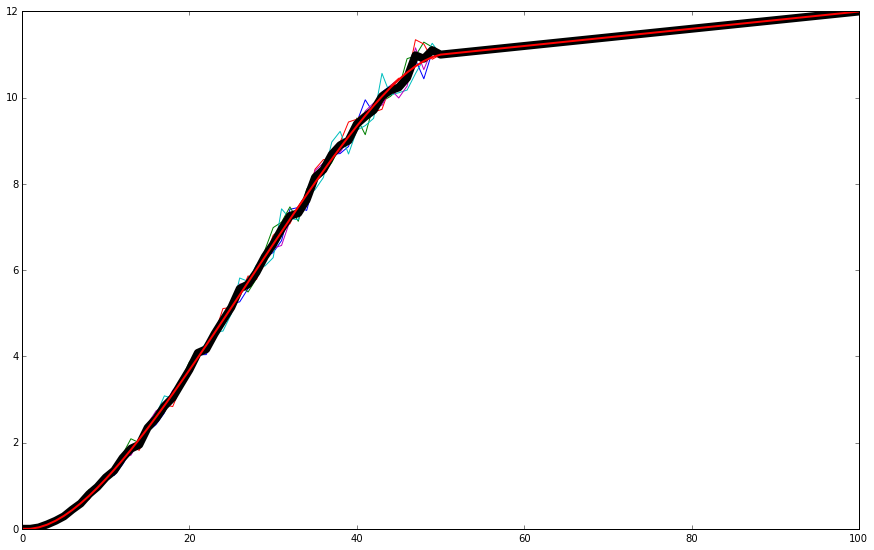

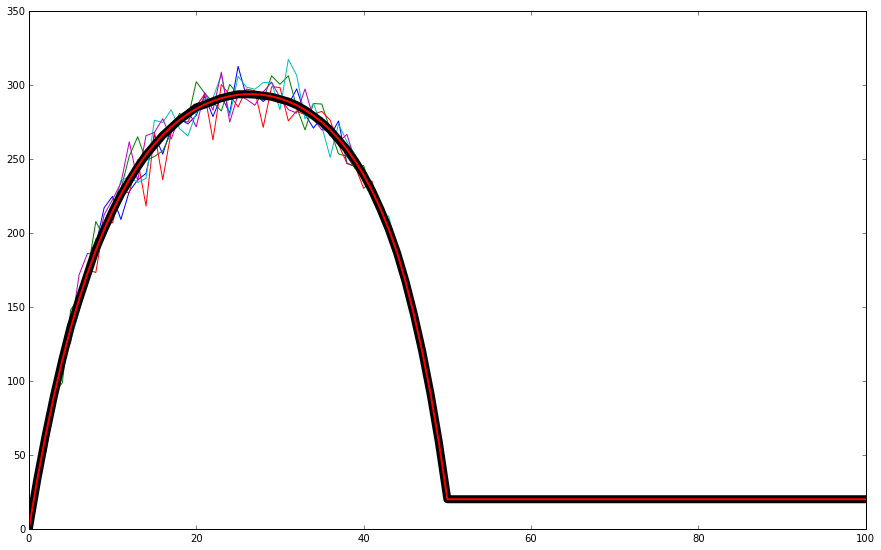

In [439]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ntest = 5
poss = np.zeros((ntest,T+R+1))
for j in np.arange(ntest):
    pos1 = np.zeros(T+R+1)
    pos2 = np.zeros(T+R+1)
    for i in np.arange(T+R+1):
        mean = expectation(record.signal[1200000], i)
        state_v = state_vector(record.signal[1200000], i)
        pos1[i] = mean[0]
        pos2[i] = state_v[0]
        vel1[i] = mean[1]
        vel2[i] = state_v[1]
    poss[j, :] = pos2
    vels[j, :] = vel2
pos_mean = np.mean(poss, axis = 0)
vel_mean = np.mean(vels, axis = 0)
for j in np.arange(ntest):
    plt.figure(1)
    plt.plot(poss[j])
plt.plot(pos_mean, lw = 8, color ='black')
plt.plot(pos1, lw = 2, color ='red')
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

for j in np.arange(ntest):
    plt.figure(2)
    plt.plot(vels[j])
plt.plot(vel_mean, lw = 8, color = 'black')
plt.plot(vel1, lw = 2, color = 'red')
